In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.mynetwork_uu import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr1 = 0.0004
lr2 = 0.0002
lr_fast = 0.0005
lr_slow = 0.00005

model = Unet(device).to(device)
# model = Unet().to(device)
cliploss = CLIPLoss(device)
mseloss = torch.nn.MSELoss()
# vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
# for x in vgg.parameters():
#     x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300

In [3]:
loss_li = []


In [4]:
def train(iteration1, iteration2, pic, source, target):
    input = pic

    # pic_f = get_features(vgg_normalize(pic), vgg)
    # print(model.parameters())
    opt = optim.Adam(model.parameters(), lr=lr1)
    for i in range(iteration1):
        opt.zero_grad()
        neo_pic = model(input)
        loss = mseloss(pic, neo_pic) * 1

        # loss = 0
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        loss.backward()
        opt.step()

        print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 50) == 0:
        #     pil.save(f"./pic1/{(i + 1) // 50}.jpg")
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)


    # torch.save(model,'unet.pth')

    # model = torch.load('unet.pth')

    # pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    opt_fast = optim.Adam(model.parameters(), lr=lr2)
    opt_slow = optim.Adam(model.parameters(), lr=lr_fast)
    # opt_loss = optim.Adam(cliploss.parameters(), lr=lr_slow)
    for i in range(iteration2):


        opt.zero_grad()
        opt_slow.zero_grad()
        opt_fast.zero_grad()

        neo_pic = model(input)

        dir_loss = 0
        # dir_loss += cliploss.forward_dir(pic, source, neo_pic, target)

        gol_loss = 0
        # gol_loss += cliploss.forward_gol(pic, source, neo_pic, target)

        content_loss = 0
        # content_loss += mseloss(pic, neo_pic)
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        patch_loss = 0
        # patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        norm_loss += cliploss.get_image_prior_losses(neo_pic)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda



        patch_loss_fast,patch_loss_slow = cliploss.forward_patch_sec(pic, source, neo_pic, target)


        for x in model.res2.parameters():
            x.requires_grad = False
        patch_loss_fast.backward(retain_graph=True)
        for x in model.res2.parameters():
            x.requires_grad = True

        for x in model.res.parameters():
            x.requires_grad = False
        for x in model.conv3.parameters():
            x.requires_grad = False
        for x in model.upsample3.parameters():
            x.requires_grad = False
        patch_loss_slow.backward(retain_graph=True)
        for x in model.res.parameters():
            x.requires_grad = True
        for x in model.conv3.parameters():
            x.requires_grad = True
        for x in model.upsample3.parameters():
            x.requires_grad = True


        loss.backward()
        opt.step()

        opt_fast.step()
        opt_slow.step()

        loss_li.append(loss.item())

        print("iter:", i + 1, "loss:", loss.item())


        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic2/{(i + 1) // 10}.jpg")

    # return  model(input)
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)


In [5]:
pil = Image.open(f"source_pic/sunflower.jpg")
ori_size = pil.size[::-1]
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
# pic = torch.ones(1, 3, 512, 512).to(device)
pic.requires_grad = False

source = "photo"
target = "Van Gogh"
# target = "the scream by Edvard Munch"
path = "result1.jpg"

In [6]:
start = time.time()
train(100, 100, pic, source, target)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

iter: 1 loss: 0.20483796298503876
iter: 2 loss: 0.1804431676864624
iter: 3 loss: 0.16039179265499115
iter: 4 loss: 0.14418062567710876
iter: 5 loss: 0.13121633231639862
iter: 6 loss: 0.1209268867969513
iter: 7 loss: 0.11235299706459045
iter: 8 loss: 0.10505189001560211
iter: 9 loss: 0.09864598512649536
iter: 10 loss: 0.0929594337940216
iter: 11 loss: 0.0877772718667984
iter: 12 loss: 0.08326919376850128
iter: 13 loss: 0.07890089601278305
iter: 14 loss: 0.07422171533107758
iter: 15 loss: 0.07143933326005936
iter: 16 loss: 0.06776725500822067
iter: 17 loss: 0.06485938280820847
iter: 18 loss: 0.06207066774368286
iter: 19 loss: 0.05950462818145752
iter: 20 loss: 0.057013750076293945
iter: 21 loss: 0.05454136058688164
iter: 22 loss: 0.052331726998090744
iter: 23 loss: 0.05072390288114548
iter: 24 loss: 0.04915348440408707
iter: 25 loss: 0.04737580567598343
iter: 26 loss: 0.04602359980344772
iter: 27 loss: 0.04480797052383423
iter: 28 loss: 0.04323139786720276
iter: 29 loss: 0.04250889644026

In [7]:
neo_pic = model(pic)
pil = topil(neo_pic.squeeze(0).cpu())
pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
pil.save(path)



# 186.4968602657318


In [8]:
# with open(file = "neo.txt", mode = "w") as file:
#     for i in loss_li:
#         file.write(str(i)+" ")


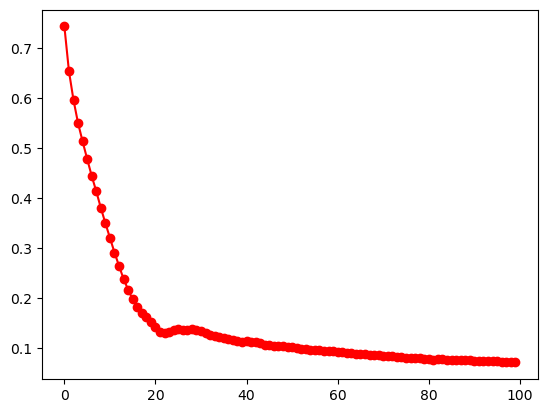

In [9]:
# import matplotlib.pyplot as plt
#
# x = [i for i in range(100)]
# plt.plot(x,loss_li,color="red",marker="o")
